Notebook to asses the [Modulation transfer function](https://en.wikipedia.org/wiki/Optical_transfer_function) (MTF) of a dataset of [microAngifil](http://www.fumedica.ch/de/home)-infused hindlimb muscles.

In several slices of the reconstructed dataset we selected line profiles from the blood vessels to the tissue.
The 10--90% region of the edge response gives us a measure of the resolution.

We fit an [error function](https://en.wikipedia.org/wiki/Error_function) to the edge profile and do a Fourier transform of the first derivative of this error function.
Per definition, this gives us the MTF of the system.


http://www.quickmtf.com/about-resolution.html
- Scanning of all lines and averaging with leveling due to zero intensity. We receive edge spread function, also called edge profile function. The distances in pixels are corrected depending on the angle of edge slope. The edge should be sloped for smooth averaging.
- Taking the first derivative from edge spread function. Thus, we receive line spread function.
- Applying discrete Fourier transform to line spread function. Thus, we receive modulation transfer function.

In [1]:
# # Hiding code in HTML export; from http://stackoverflow.com/a/34043321/323100
# from IPython.display import display
# from IPython.display import HTML
# import IPython.core.display as di

# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
# HTML('<style>{}</style>'.format(CSS))

In [2]:
import platform
import os
import glob
import numpy
import matplotlib.pylab as plt
%matplotlib inline
import seaborn
import scipy
from scipy.optimize import curve_fit
import skimage.measure
import skimage.draw

plt.rc('image', cmap='gray', interpolation='nearest') # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [3]:
# Load Images from different locations depending if we run this notebook on Linux or Windows
if 'debian' in platform.dist():
    RootFolder = '/home/habi/uCT-Archive-Online/'
else:
    RootFolder = 'O:/'
Folder = os.path.join(RootFolder, 'Laura/MicroCT Datasets/Hindlimbs_M12-M20_2_58um/M19_Hindlimb_L_2_58um/Rec')
Files = glob.glob(os.path.join(Folder, '*.xls'))
Data = [numpy.genfromtxt(i,delimiter="\t",skip_header=1, usecols=1) for i in Files]

In [4]:
ImageNames = sorted(glob.glob(os.path.join(Folder, '*.bmp')))
numpy.random.seed(1796)
NumberOfImages = 5
ChosenImageNames = [i for i in numpy.random.choice(ImageNames,NumberOfImages)]
ChosenImages = [scipy.misc.imread(i, flatten=True) for i in ChosenImageNames]
print('We randomly chose these images from the dataset')
for i in ChosenImageNames:
    print('\t- %s' % os.path.basename(i))

We randomly chose these images from the dataset
	- M19-Hindlimb-left-2-58um_rec3673.bmp
	- M19-Hindlimb-left-2-58um_rec0376.bmp
	- M19-Hindlimb-left-2-58um_rec5578.bmp
	- M19-Hindlimb-left-2-58um_rec1873.bmp
	- M19-Hindlimb-left-2-58um_rec0478.bmp


In [5]:
## Test line profile thing...
# numpy.random.seed(1796)
# testimage = numpy.zeros([10, 10])
# testimage[:5,:5]=0.5
# testimage[-5:,:5]=1
# testimage[-5:,-5:]=numpy.random.rand(5,5)
# testimage[-6::2,-6:]=1
# plt.imshow(testimage)

# StartPoint = [0,0]
# EndPoint = [9,9]
# LineWidth = 1

# plt.subplot(121)
# plt.imshow(testimage)
# plt.plot([StartPoint[0], EndPoint[0]],[StartPoint[1], EndPoint[1]], marker='o')
# plt.subplot(122)
# plt.plot(skimage.measure.profile_line(testimage,StartPoint[::-1],EndPoint[::-1], linewidth=LineWidth))
# plt.show()

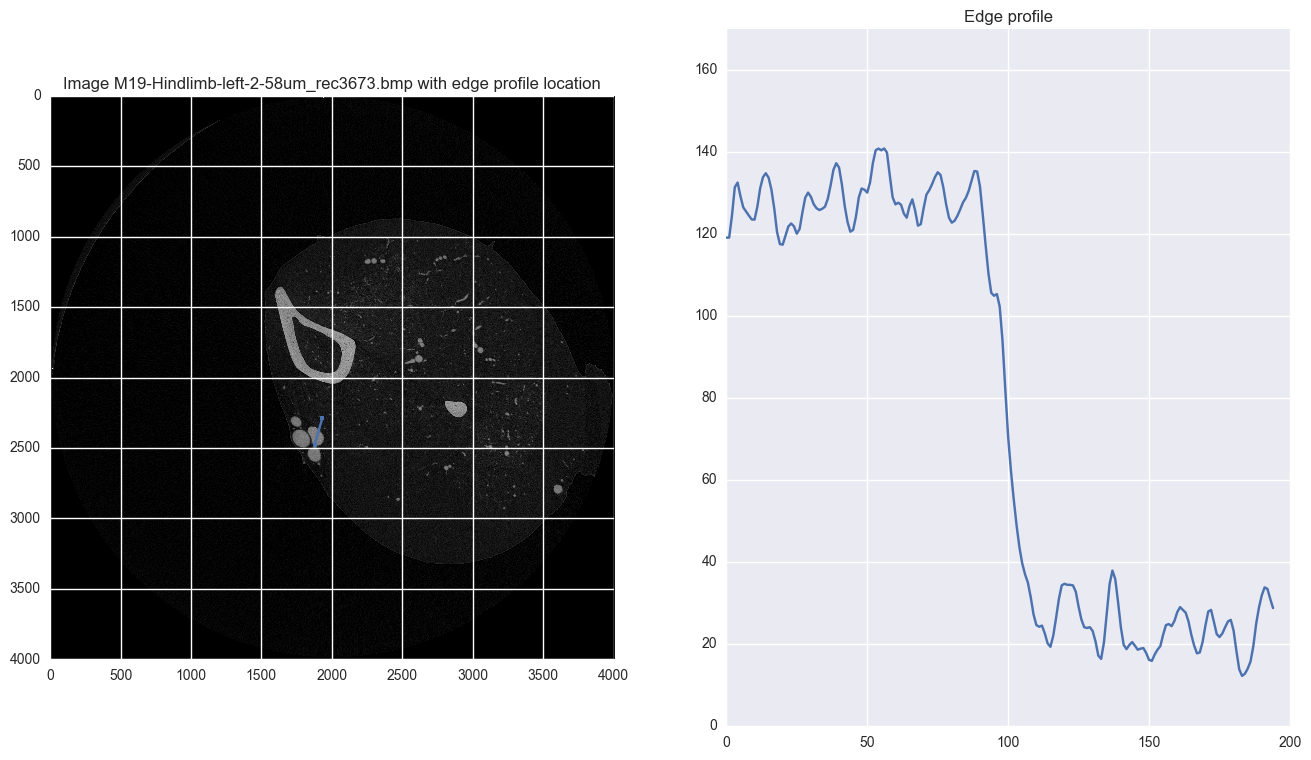

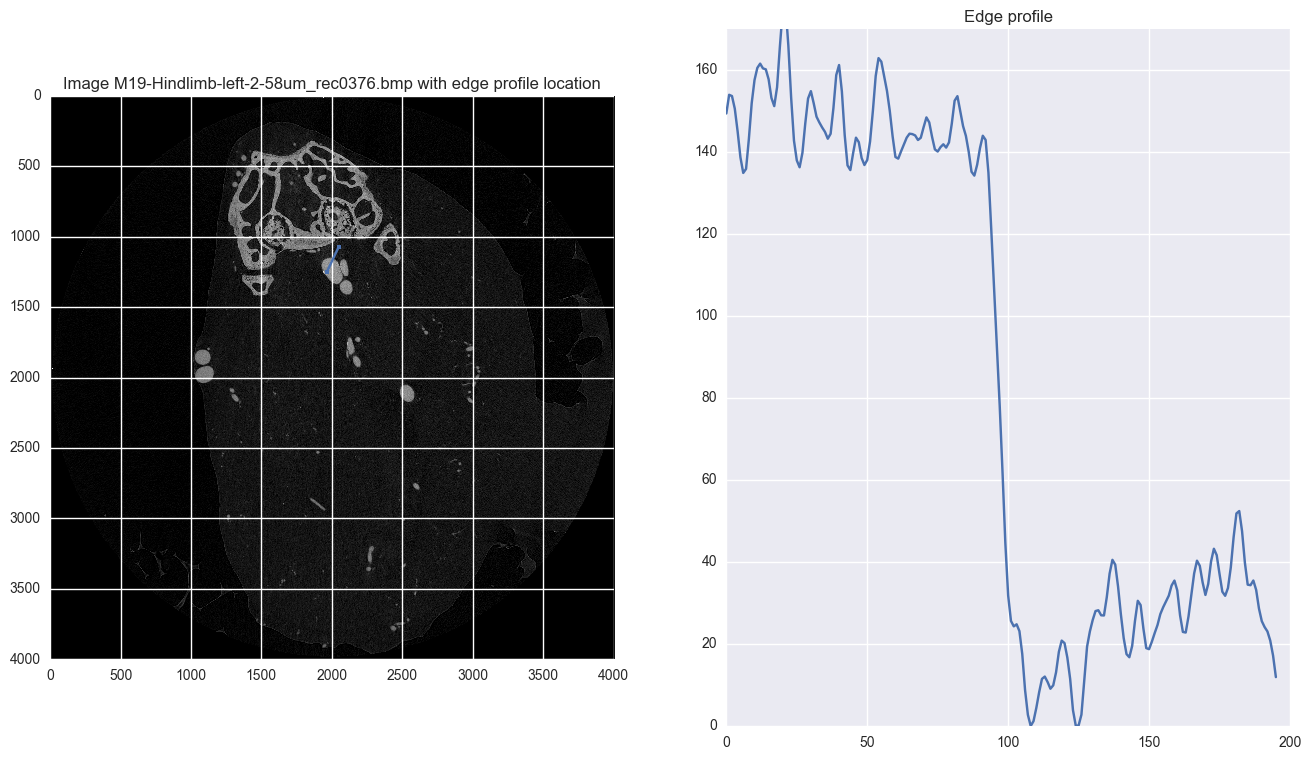

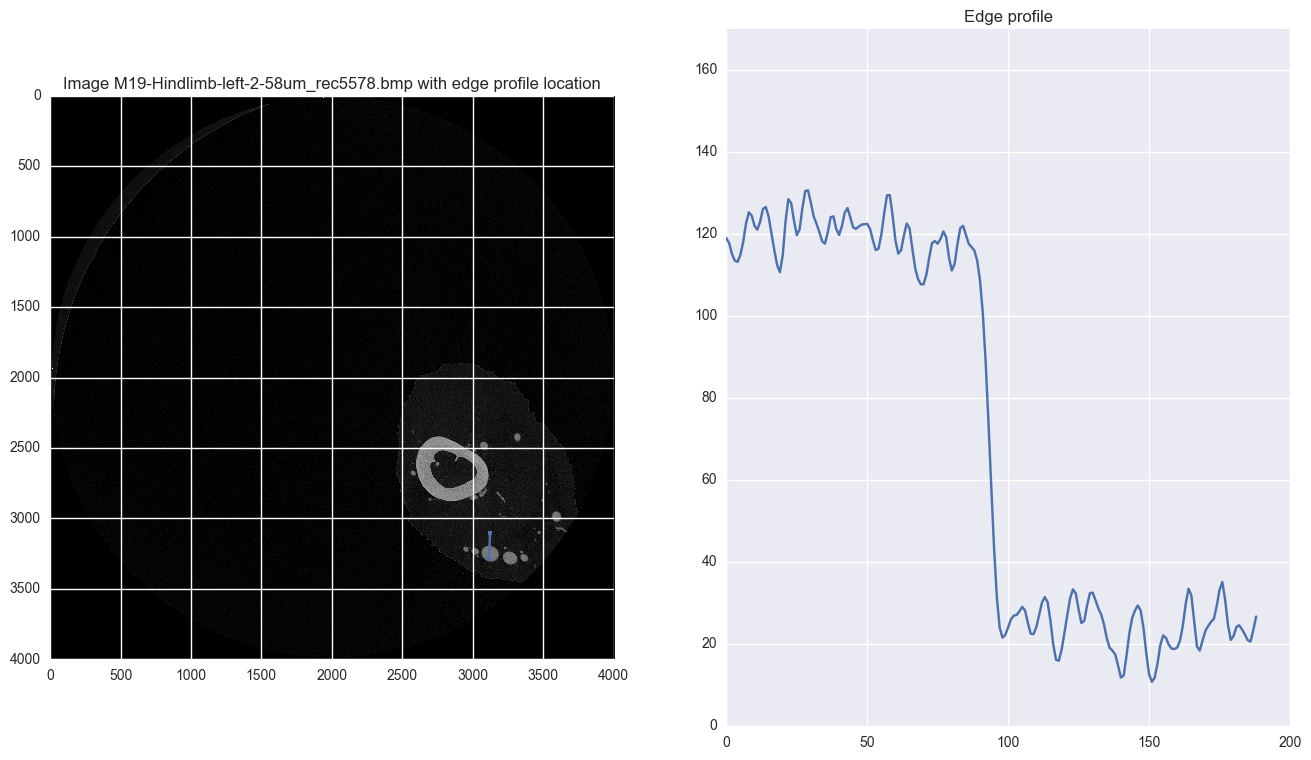

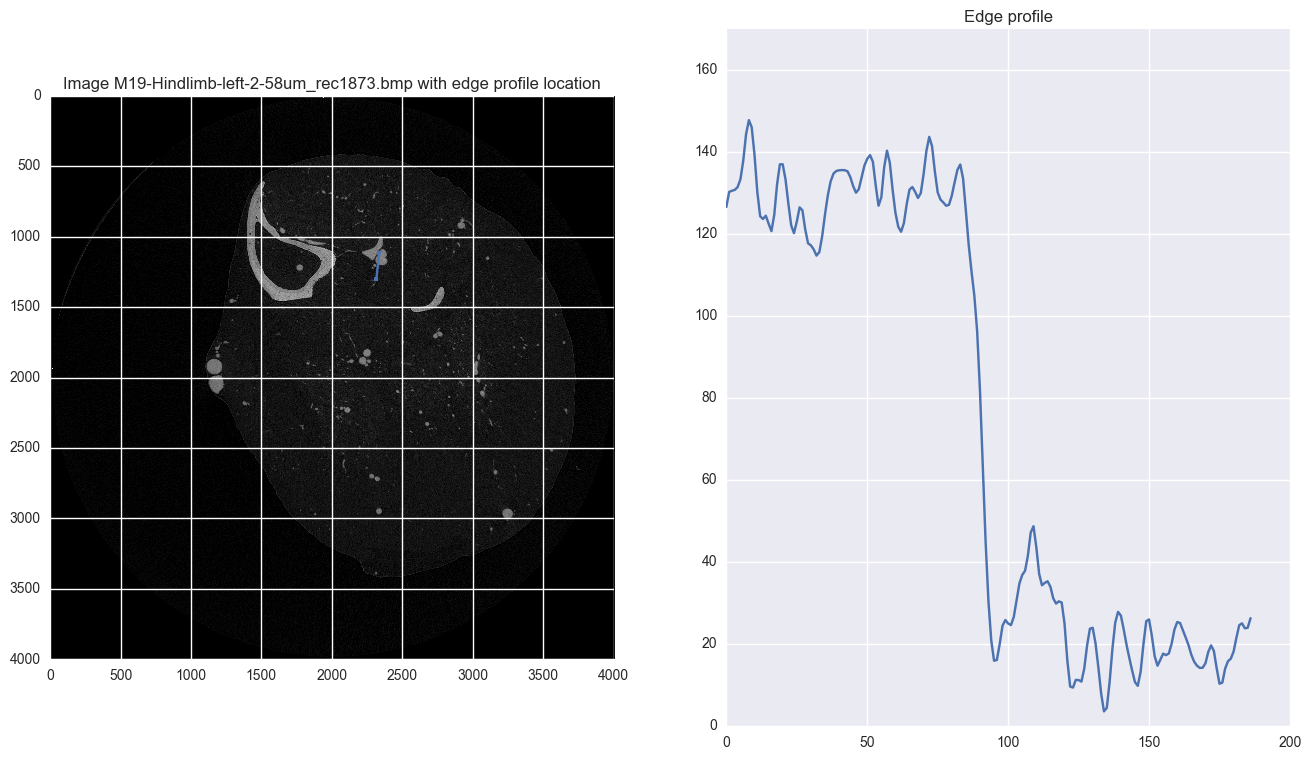

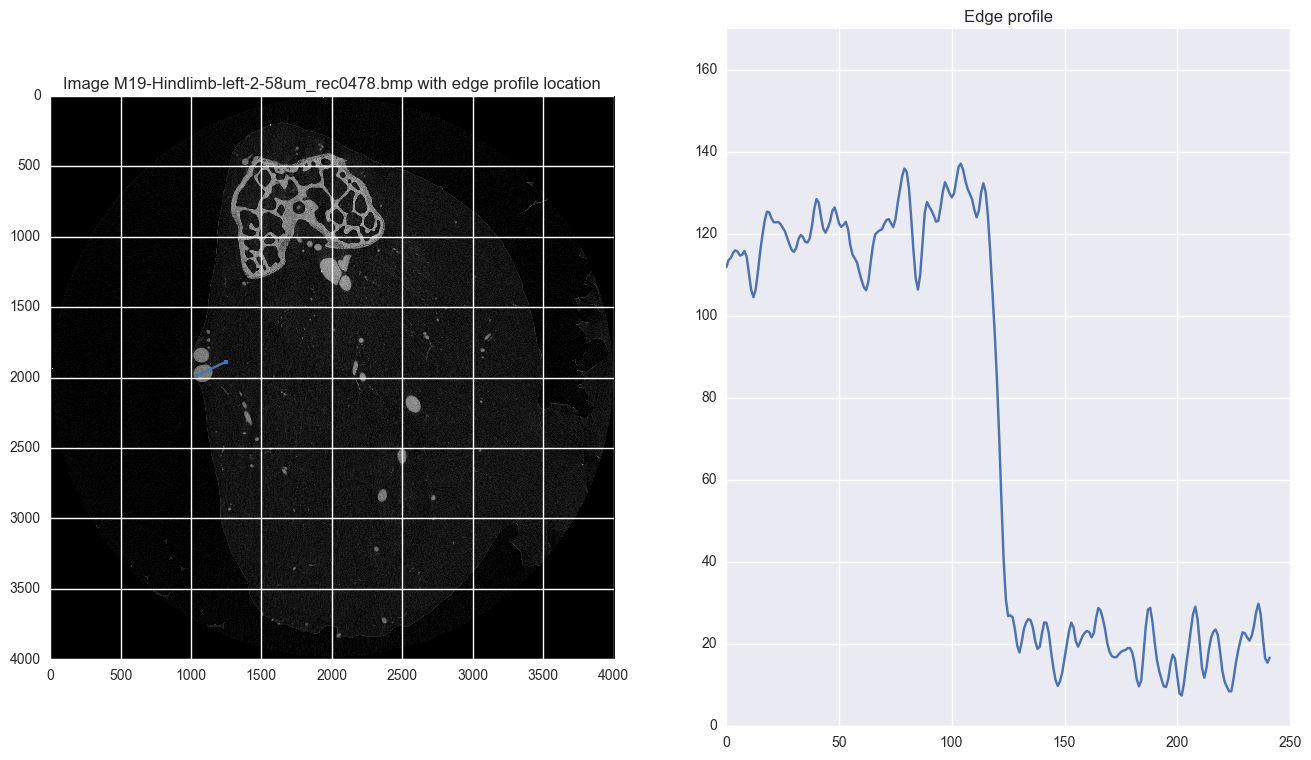

In [14]:
# In Fiji we selected the coordinates of the five randomly selected images.
# With the random seed of 1796 these 
# - M19-Hindlimb-left-2-58um_rec3673.bmp
# - M19-Hindlimb-left-2-58um_rec0376.bmp
# - M19-Hindlimb-left-2-58um_rec5578.bmp
# - M19-Hindlimb-left-2-58um_rec1873.bmp
# - M19-Hindlimb-left-2-58um_rec0478.bmp
# The start and end points of the line profiles from a filled blood vessel are given below,
# the line profiles are used for further calculations

StartPoint = [[1878,2475], [1965,1249], [3115,3291], [2336,1113], [1034,1988]]
EndPoint =   [[1932,2289], [2048,1073], [3123,3104], [2316,1297], [1252,1886]]

EdgeProfiles = [None] * len(ChosenImages)
for c,i in enumerate(ChosenImages):
    plt.subplot(121)
    plt.imshow(i)
    plt.plot([StartPoint[c][0], EndPoint[c][0]],[StartPoint[c][1], EndPoint[c][1]], marker='.')
    plt.xlim([-1,numpy.shape(i)[0]])
    plt.ylim([numpy.shape(i)[1],-1])
    plt.title('Image %s with edge profile location' % os.path.basename(ChosenImageNames[c]))
    plt.subplot(122)
    EdgeProfiles[c] = skimage.measure.profile_line(i,StartPoint[c][::-1],EndPoint[c][::-1],
                                                   linewidth=3) # we flip the start and end point coordinates for matplotlib reasons
    plt.plot(EdgeProfiles[c])
    plt.title('Edge profile')
    plt.ylim([0,170])
    plt.show()

The 10-90% edge response (gray values 35-118) is 17 pixels wide (px 91-108)


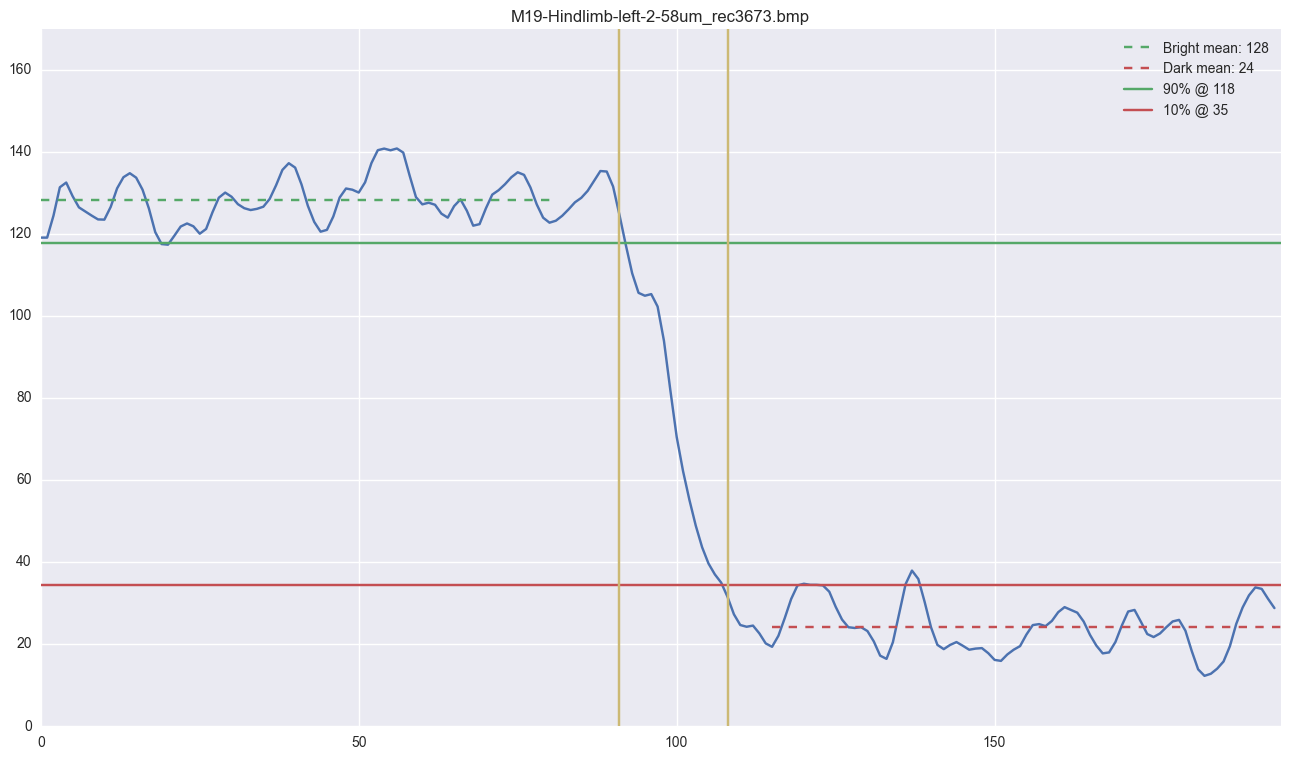

The 10-90% edge response (gray values 40-136) is 8 pixels wide (px 92-100)


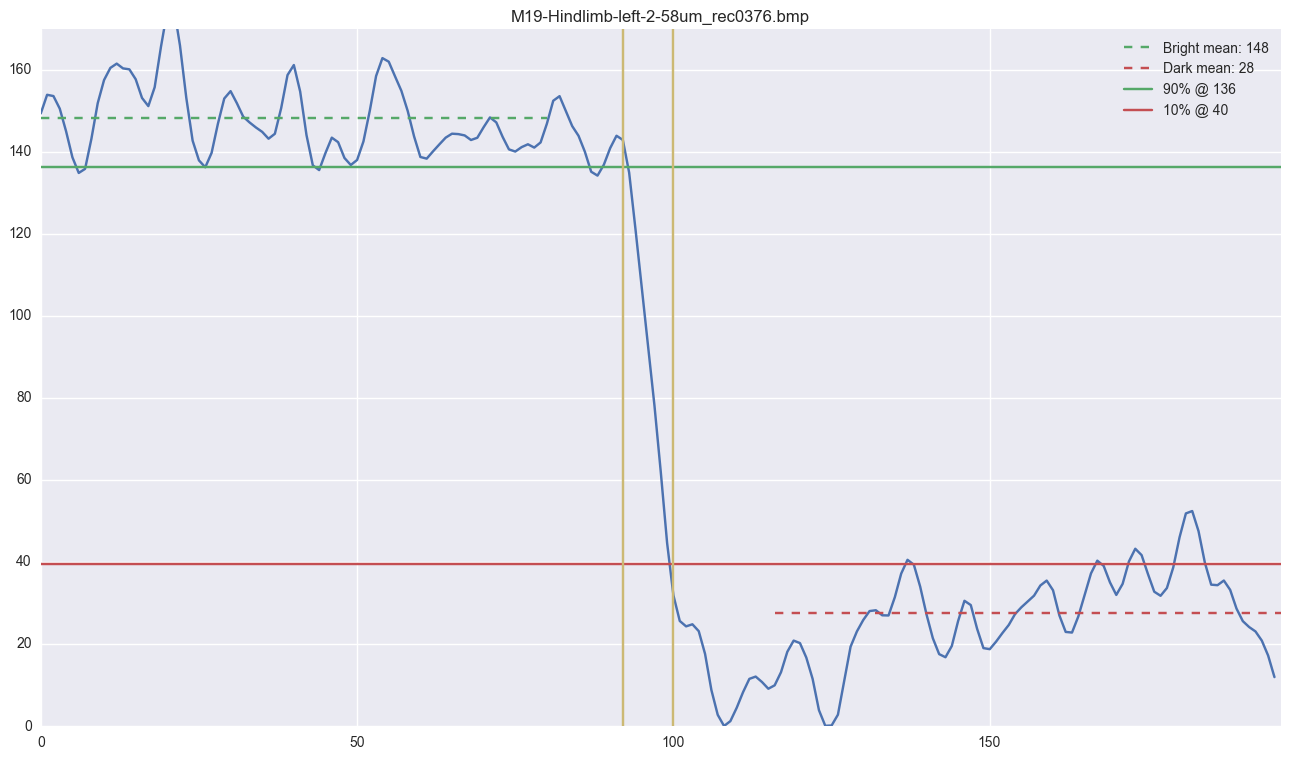

The 10-90% edge response (gray values 33-111) is 7 pixels wide (px 89-96)


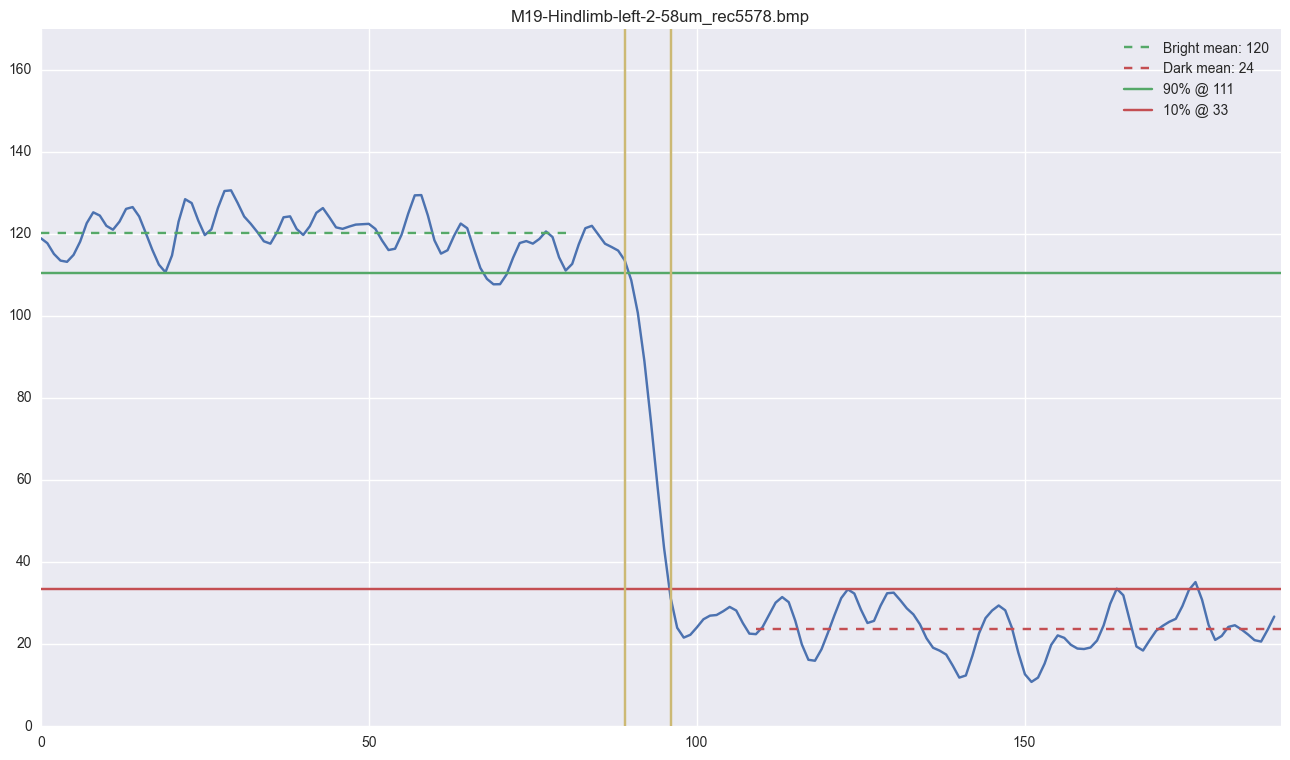

The 10-90% edge response (gray values 32-119) is 8 pixels wide (px 85-93)


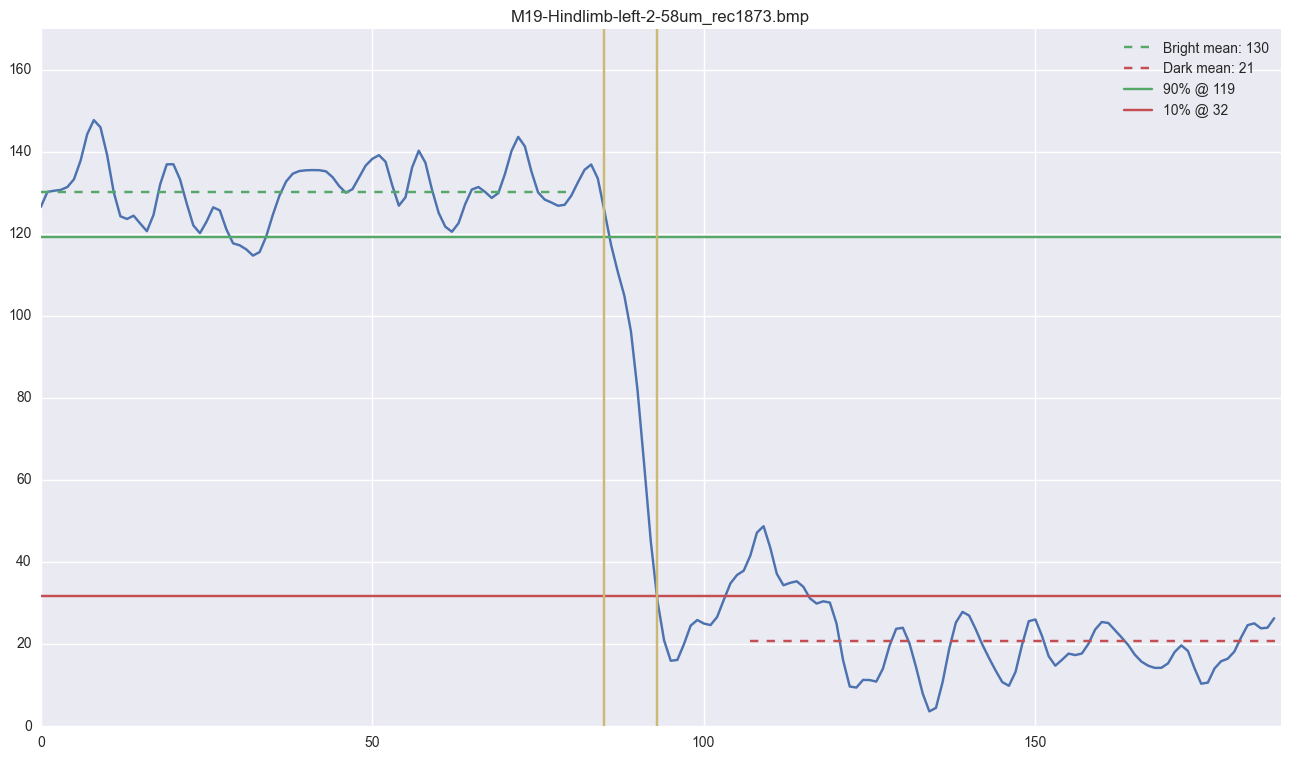

The 10-90% edge response (gray values 29-109) is 8 pixels wide (px 117-125)


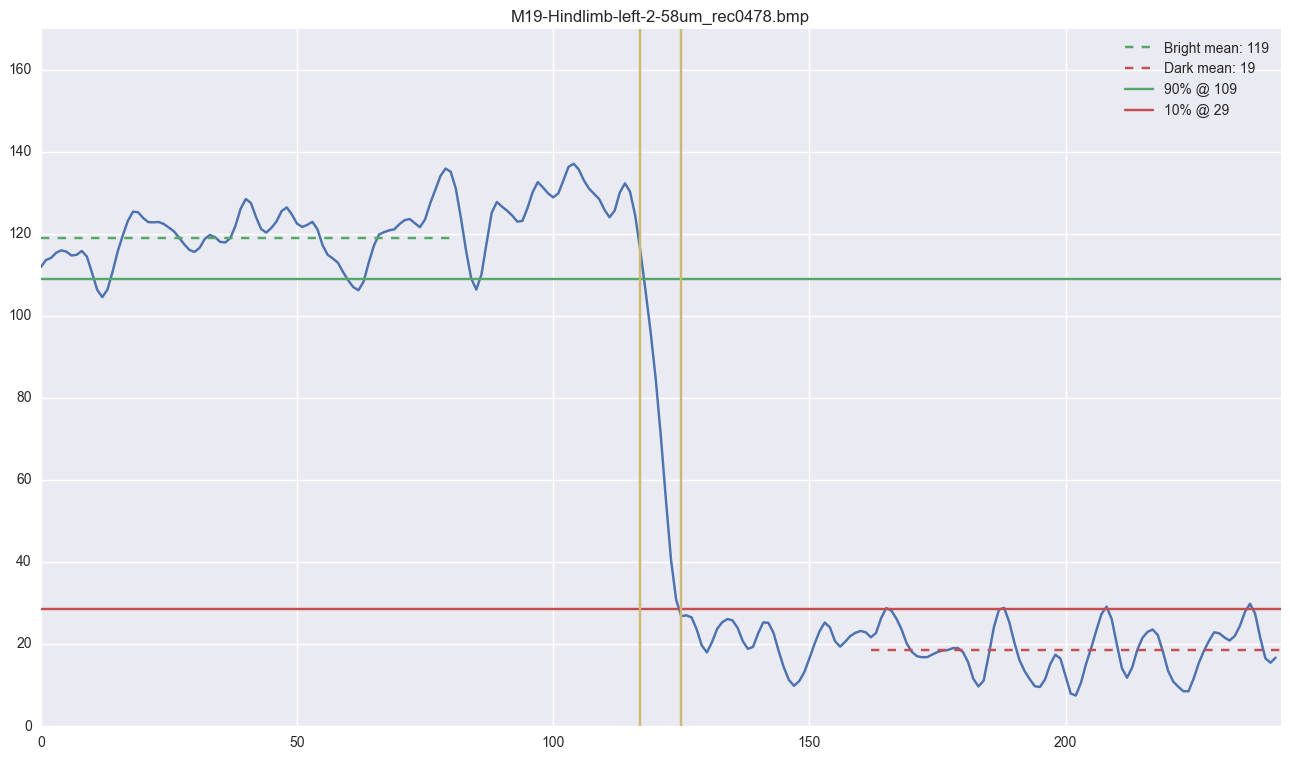

In [15]:
meancounter=80
for c,i in enumerate(EdgeProfiles):
    uaf_mean = numpy.mean(i[:meancounter])
    tissue_mean = numpy.mean(i[-meancounter:])
    mean_distance_drop = 0.1 * (uaf_mean - tissue_mean)
    start_of_edge = numpy.where(i>uaf_mean - mean_distance_drop)[0][-1]
    end_of_ege = numpy.where(i<tissue_mean + mean_distance_drop)[0][0]
    distance = end_of_ege - start_of_edge
    print('The 10-90%% edge response (gray values %0.f-%0.f) is %s pixels wide (px %s-%s)' % (tissue_mean + mean_distance_drop,
                                                                                              uaf_mean - mean_distance_drop,
                                                                                              distance,
                                                                                              start_of_edge,
                                                                                              end_of_ege))
    plt.plot(i, c=seaborn.color_palette()[0])
    plt.axhline(y=uaf_mean,
                xmin=0,
                xmax=(float(meancounter)/len(EdgeProfiles[c])),
                c=seaborn.color_palette()[1], label='Bright mean: %0.f' % uaf_mean, ls='dashed')
    plt.axhline(y=tissue_mean,
                xmin=1-(float(meancounter)/len(EdgeProfiles[c])),
                xmax=len(EdgeProfiles[c]),
                c=seaborn.color_palette()[2], label='Dark mean: %0.f' % tissue_mean, ls='dashed')
    plt.axhline(uaf_mean - mean_distance_drop, c=seaborn.color_palette()[1],
                label='90%% @ %0.f' % (uaf_mean - mean_distance_drop))
    plt.axhline(tissue_mean + mean_distance_drop, c=seaborn.color_palette()[2],
                label='10%% @ %0.f' % (tissue_mean + mean_distance_drop))
    plt.axvline(start_of_edge, c=seaborn.color_palette()[4])    
    plt.axvline(end_of_ege, c=seaborn.color_palette()[4])
    plt.legend(loc='best')
    plt.title(os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([0,170])      
    plt.show()
    

In [43]:
def function_error(x, a, b):
    # Fit an error function (https://en.wikipedia.org/wiki/Error_function) to the data
    return a * scipy.special.erf(-x)+b

def fit_errorfunction(noisydata, scalefactor=0.5):
    start_of_edge = numpy.where(noisydata>numpy.mean(noisydata[:meancounter]))[0][-1]
    end_of_ege = numpy.where(noisydata<numpy.mean(noisydata[-meancounter:]))[0][0]
    edgelocation = start_of_edge + (end_of_ege - start_of_edge)/2
    xdata = numpy.linspace(-scalefactor*edgelocation, scalefactor*(-edgelocation+len(noisydata)), len(noisydata))
    popt, pcov = curve_fit(function_error, xdata, noisydata)
    return popt[0] * scipy.special.erf(-xdata)+popt[1]

In [44]:
def linespread_function(data):
    return numpy.diff(data)

def mtf(data):
    return numpy.abs(numpy.fft.fft(linespread_function(data))) #[0:len(data)//2]

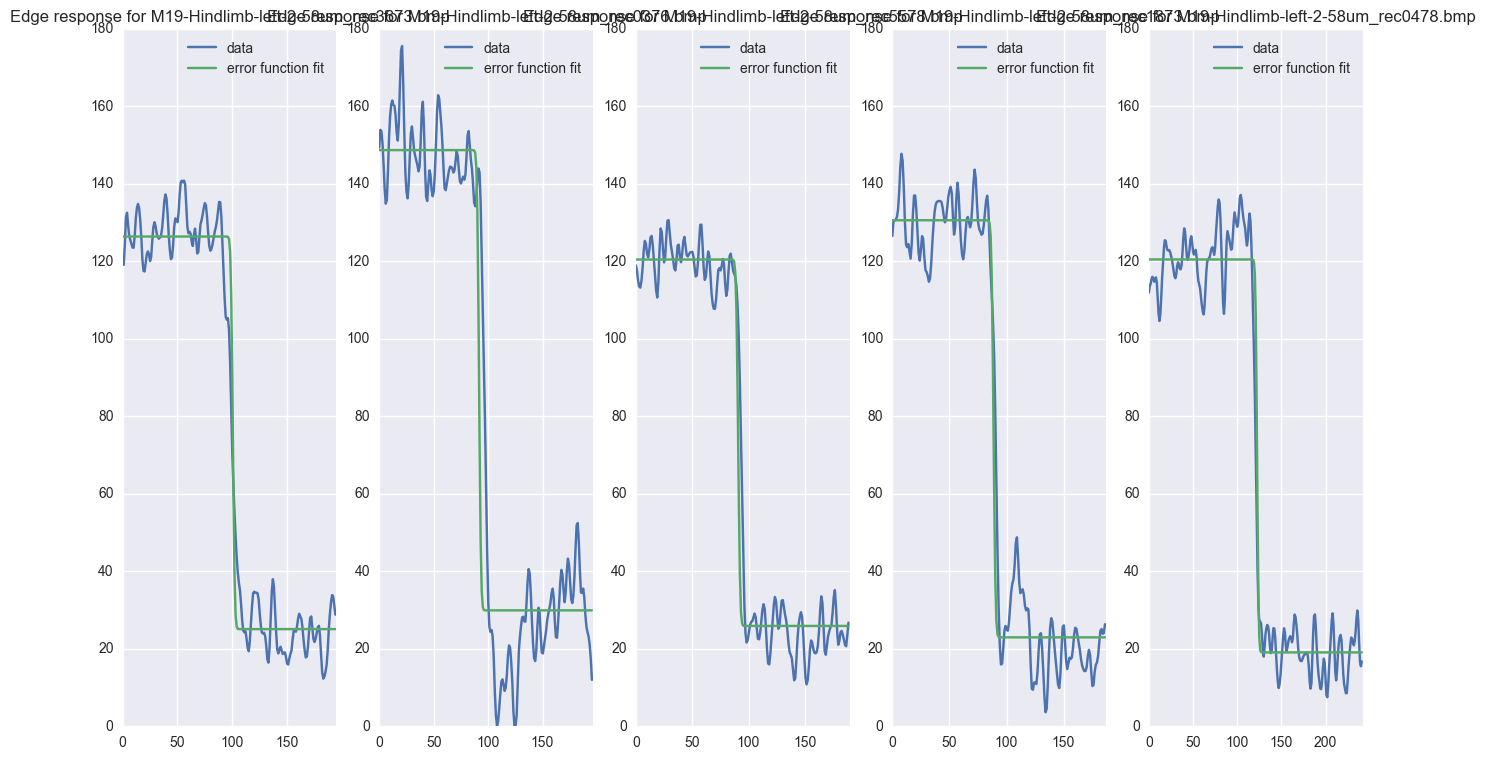

In [45]:
for c,i in enumerate(EdgeProfiles):
    plt.subplot(1,len(EdgeProfiles),c+1)
    plt.plot(i, label='data')
    plt.plot(fit_errorfunction(i), label='error function fit')
    plt.legend(loc='best')
    plt.title('Edge response for %s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([0,180])    
plt.show()

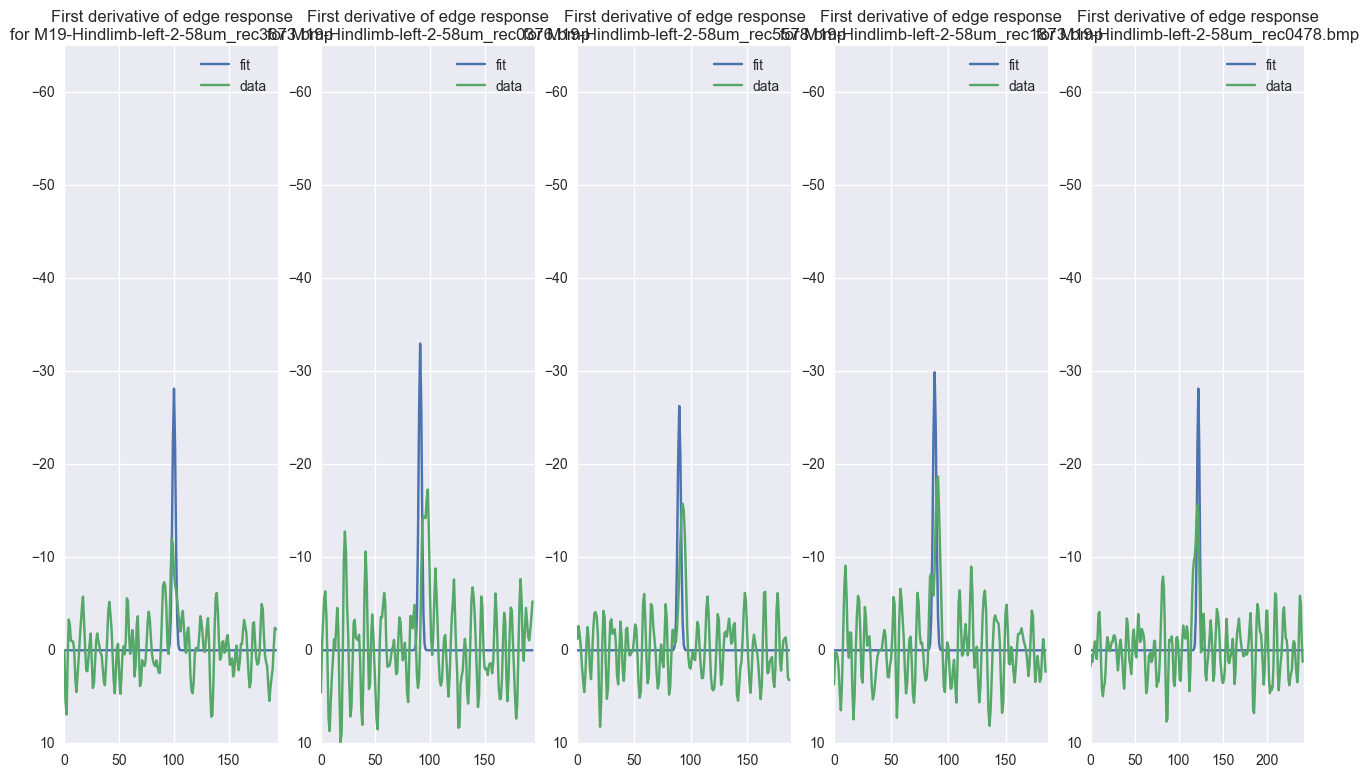

In [46]:
for c, i in enumerate(EdgeProfiles):
    plt.subplot(1, len(EdgeProfiles),c+1)
    plt.plot(linespread_function(fit_errorfunction(i)), label='fit')
    plt.plot(linespread_function(i), label='data')
    plt.legend(loc='best')
    plt.title('First derivative of edge response\nfor %s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)])
    plt.ylim([10,-65])
plt.show()

In [47]:
def function_polynomial(x, a, b, c, d, e, f, g):
    # Fit a sixth order polynomial to the data
    return a * x**6 + b* x**5 + c* x**4 + d * x**3 + e* x**2 + g

def fit_polynomial(noisydata):
    start_of_edge = numpy.where(noisydata>numpy.mean(noisydata[:meancounter]))[0][-1]
    end_of_ege = numpy.where(noisydata<numpy.mean(noisydata[-meancounter:]))[0][0]
    edgelocation = start_of_edge + (end_of_ege - start_of_edge)/2
    xdata = numpy.linspace(-edgelocation, -edgelocation+len(noisydata), len(noisydata))
    popt, pcov = curve_fit(function_polynomial, xdata, noisydata)
    return popt[0] * xdata**6 + popt[1] * xdata**5 + popt[2] * xdata**4 + popt[3] * xdata**3 + popt[4] * xdata**2 + popt[5]

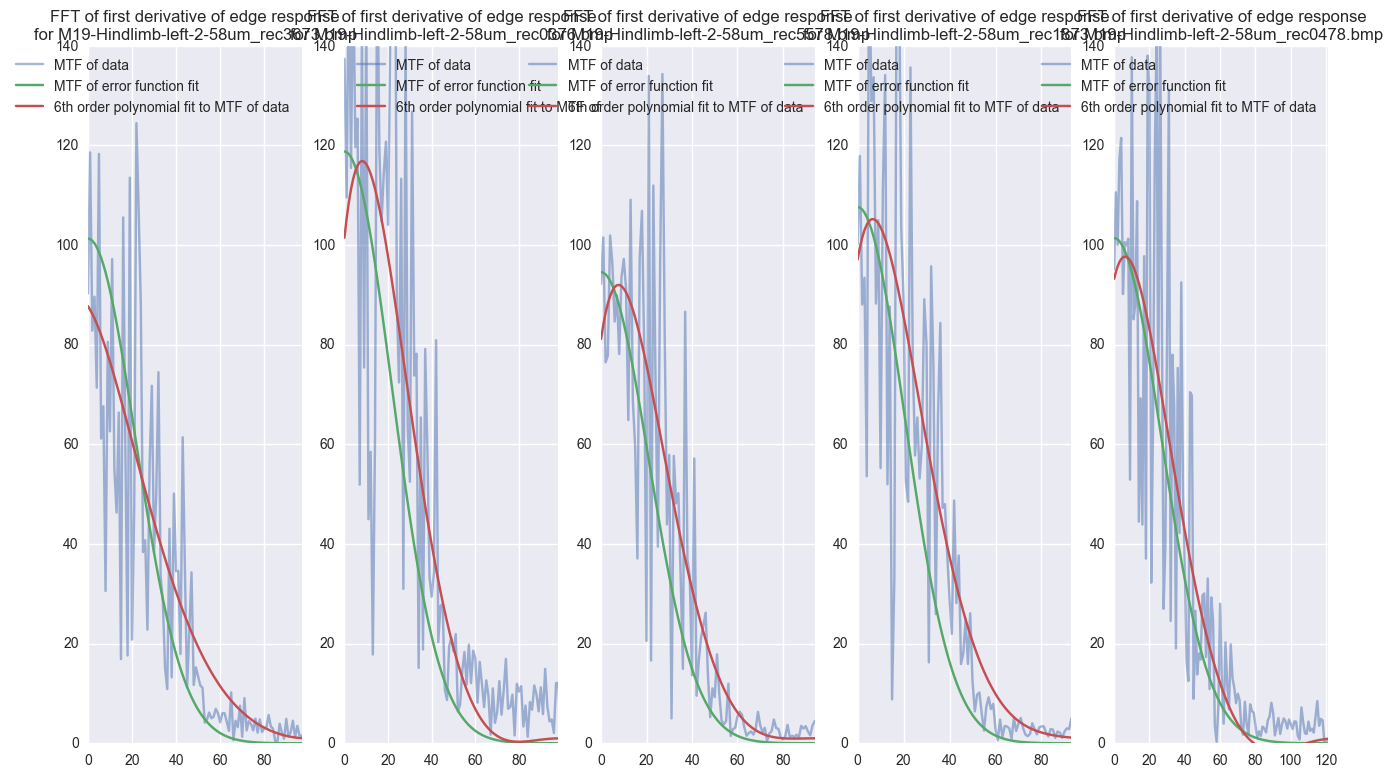

In [48]:
for c, i in enumerate(EdgeProfiles):
    plt.subplot(1, len(EdgeProfiles),c+1)
    plt.plot(mtf(i), label='MTF of data', alpha=0.5)    
    plt.plot(mtf(fit_errorfunction(i)), label='MTF of error function fit')
    plt.plot(fit_polynomial(mtf(i)), label='6th order polynomial fit to MTF of data')
    plt.legend(loc='best')
    plt.title('FFT of first derivative of edge response\nfor %s' % os.path.basename(ChosenImageNames[c]))
    plt.xlim([0,len(i)//2])    
    plt.ylim([0,140])
    plt.legend(loc='best')
plt.show()